<a href="https://colab.research.google.com/github/buxkirill/reboot_DA/blob/main/ml/homeworks/homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import re
from collections import Counter
from google.colab import files
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, roc_curve

warnings.filterwarnings('ignore')
#files.upload()

ДЗ №2

Файл titanicdf.csv, задачи:
###1. Предобработать данные (пропуски, замена текста, дубликаты и т.д)


In [2]:
df = pd.read_csv('titanic.csv', sep=',')
df.drop_duplicates(inplace=True)
df.Age.fillna(value=df.Age.mean(), inplace=True)
df = pd.get_dummies(df, columns=['Sex', 'Embarked'])
df.drop(['Ticket', 'Cabin', 'PassengerId'], axis=1, inplace=True)
df.Name = df.Name.apply(lambda x: re.sub(r"[-()\"#/@;:<>{}=~|.?,]", "", x).lower())
df.sample(5)

,Survived,Pclass,Name,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
251,0,3,strom mrs wilhelm elna matilda persson,29.0,1,1,10.4625,1,0,0,0,1
50,0,3,panula master juha niilo,7.0,4,1,39.6875,0,1,0,0,1
670,1,2,brown mrs thomas william solomon elizabeth cat...,40.0,1,1,39.0000,1,0,0,0,1
418,0,2,matthews mr william john,30.0,0,0,13.0000,0,1,0,0,1
676,0,3,sawyer mr frederick charles,24.5,0,0,8.0500,0,1,0,0,1


In [3]:
# самые встречаемые слова в Name
words = []
for name in df.Name.values:
  words.extend(name.split(' '))
Counter(words).most_common(5)

[('mr', 521), ('miss', 182), ('mrs', 129), ('william', 64), ('john', 44)]

In [4]:
# добавим еще несколько признаков из текста
df['is_mr'] = df.Name.apply(lambda x: 'mr' in x)
df['is_miss'] = df.Name.apply(lambda x: 'miss' in x)
df['is_mrs'] = df.Name.apply(lambda x: 'mrs' in x)
df.replace(True, 1, inplace=True)
df.replace(False, 0, inplace=True)
df.sample(5)

,Survived,Pclass,Name,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,is_mr,is_miss,is_mrs
216,1,3,honkanen miss eliina,27.0,0,0,7.9250,1,0,0,0,1,0.0,1.0,0.0
638,0,3,panula mrs juha maria emilia ojala,41.0,0,5,39.6875,1,0,0,0,1,1.0,0.0,1.0
551,0,2,sharp mr percival james r,27.0,0,0,26.0000,0,1,0,0,1,1.0,0.0,0.0
796,1,1,leader dr alice farnham,49.0,0,0,25.9292,1,0,0,0,1,0.0,0.0,0.0
724,1,1,chambers mr norman campbell,27.0,1,0,53.1000,0,1,0,0,1,1.0,0.0,0.0


###2. Использовать для классификации sklearn.ensemble.RandomForestClassifier
###3. Подобрать лучшие гиперпараметры (n_estimators, criterion, max_depth)


In [5]:
X_train, X_test, y_train, y_test =  train_test_split(df.drop(['Survived', 'Name'], axis=1), 
                                                     df.Survived, test_size=0.3, random_state=42)

In [6]:
params = {'n_estimators': [40, 60, 80, 100, 120, 140, 160, 180],
          'criterion': ['gini', 'entropy'],
          'max_depth': [None, 2, 4, 6, 8, 10]}

grid = GridSearchCV(RandomForestClassifier(random_state=42), params)
grid.fit(X_train, y_train)
grid.best_params_

{'criterion': 'gini', 'max_depth': 6, 'n_estimators': 100}

###4. Провести кроссвалидацию модели


In [7]:
clf = RandomForestClassifier(criterion='gini', max_depth=6, n_estimators=100, random_state=42)

In [8]:
cv = KFold(n_splits=5, random_state=42)
metrics = ['precision', 'recall', 'f1']
for metric in metrics:
  print(f'Cross validation with {metric} is:', cross_val_score(clf, X_train, y_train, cv=cv, scoring=metric).mean())


Cross validation with precision is: 0.8246559545106056
Cross validation with recall is: 0.6845962059620596
Cross validation with f1 is: 0.7476840687667023


###5. Оценить метрики бинарной классификации (Precision, recall, f1)


In [9]:
clf.fit(X_train, y_train)
print('Precision', precision_score(y_test, clf.predict(X_test)))
print('Recall', recall_score(y_test, clf.predict(X_test)))
print('F1', f1_score(y_test, clf.predict(X_test)))
#print('roc_auc_score', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

Precision 0.8105263157894737
Recall 0.6936936936936937
F1 0.7475728155339806


###6. Построить ROC-кривую для оценки качества классификатора

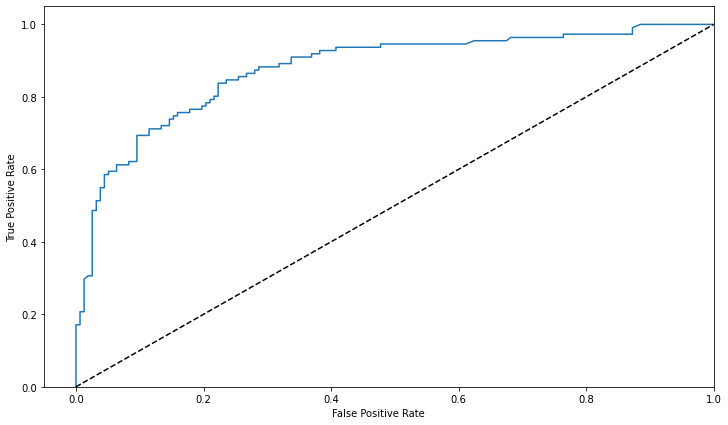

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])

plt.figure(figsize=(12, 7))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()